In [337]:
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\jdobe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [338]:
import yfinance as yf
import numpy as np
import arch
import matplotlib.pyplot as plt

In [339]:
ticker = "^GSPC"
data = yf.download(ticker, start="1960-01-01", end="2023-01-01")

C:\Users\jdobe\AppData\Local\Temp\ipykernel_6324\2793084089.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="1960-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [340]:
print(data.head())
print(data.shape)

Price           Close       High        Low       Open   Volume
Ticker          ^GSPC      ^GSPC      ^GSPC      ^GSPC    ^GSPC
Date                                                           
1960-01-04  59.910000  59.910000  59.910000  59.910000  3990000
1960-01-05  60.389999  60.389999  60.389999  60.389999  3710000
1960-01-06  60.130001  60.130001  60.130001  60.130001  3730000
1960-01-07  59.689999  59.689999  59.689999  59.689999  3310000
1960-01-08  59.500000  59.500000  59.500000  59.500000  3290000
(15858, 5)


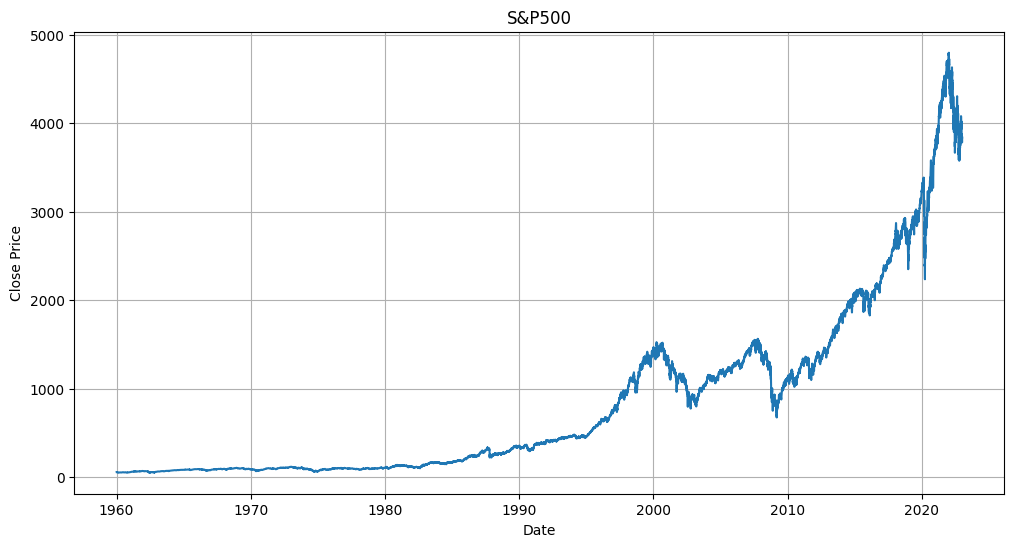

In [341]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title('S&P500')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

## Feature Engineering

In [342]:
# Create variable Log Returns and further
data["DailyReturn"] = np.log(data["Close"]).diff()
data = data.iloc[1:]

In [343]:
data.head()

Price,Close,High,Low,Open,Volume,DailyReturn
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,
1960-01-05,60.389999,60.389999,60.389999,60.389999,3710000,0.007980
1960-01-06,60.130001,60.130001,60.130001,60.130001,3730000,-0.004315
1960-01-07,59.689999,59.689999,59.689999,59.689999,3310000,-0.007344
1960-01-08,59.500000,59.500000,59.500000,59.500000,3290000,-0.003188
1960-01-11,58.770000,58.770000,58.770000,58.770000,3470000,-0.012345


## GARCH(1,1) Model for Volatility Forecast



In [344]:
model = arch.arch_model(data["DailyReturn"]*1000, vol="GARCH", p=1, q=1)
model_fit = model.fit()
print(model_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 923796090312.3402
Iteration:      2,   Func. Count:     14,   Neg. LLF: 12188402.664294241
Iteration:      3,   Func. Count:     21,   Neg. LLF: 56316.15451782483
Iteration:      4,   Func. Count:     27,   Neg. LLF: 56192.376620714
Iteration:      5,   Func. Count:     33,   Neg. LLF: 5583550820.0031395
Iteration:      6,   Func. Count:     39,   Neg. LLF: 56370.391117195555
Iteration:      7,   Func. Count:     45,   Neg. LLF: 56169.7555719136
Iteration:      8,   Func. Count:     51,   Neg. LLF: 56178.99098546479
Iteration:      9,   Func. Count:     57,   Neg. LLF: 56157.648427601016
Iteration:     10,   Func. Count:     62,   Neg. LLF: 56157.628385307726
Iteration:     11,   Func. Count:     67,   Neg. LLF: 56157.628269854904
Iteration:     12,   Func. Count:     72,   Neg. LLF: 56157.628261777616
Iteration:     13,   Func. Count:     76,   Neg. LLF: 56157.62826177861
Optimization terminated successfully    (Exit mode 0)
      

In [345]:
data['GARCH_volatility'] = model_fit.conditional_volatility
data['inv_vol'] = 1 / data['GARCH_volatility']
data.head()

Price,Close,High,Low,Open,Volume,DailyReturn,GARCH_volatility,inv_vol
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,
Date,,,,,,,,
1960-01-05,60.389999,60.389999,60.389999,60.389999,3710000,0.007980,7.376043,0.135574
1960-01-06,60.130001,60.130001,60.130001,60.130001,3730000,-0.004315,7.429550,0.134598
1960-01-07,59.689999,59.689999,59.689999,59.689999,3310000,-0.007344,7.262138,0.137701
1960-01-08,59.500000,59.500000,59.500000,59.500000,3290000,-0.003188,7.365763,0.135763
1960-01-11,58.770000,58.770000,58.770000,58.770000,3470000,-0.012345,7.138952,0.140077


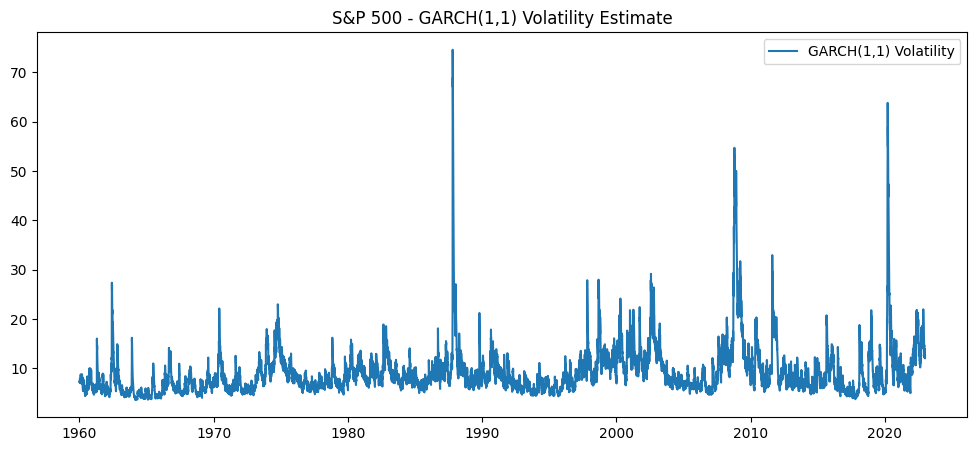

In [346]:
plt.figure(figsize=(12,5))
plt.plot(data['GARCH_volatility'], label='GARCH(1,1) Volatility')
plt.title('S&P 500 - GARCH(1,1) Volatility Estimate')
plt.legend()
plt.show()

## Reproducing results from [Christofferson and Diebold](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=453803)

In [347]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

### Daily, Weekly, Monthly, Quarterly, Semiannual and Yearly sign predictions
Using the volatility, we want now to predict the sign of asset returns for different time horizons.

In [348]:
# window_size = 1250  ## training samples
# test_size = 10000   ## rolling predictions

# # 1, 5, 20, 60, 120 and 250 day ahead sign targets
# for horizon in [1]:#, 5, 20, 60, 125, 250]:
#     data[f"{horizon}d_Return"] = np.log(data['Close']).diff(horizon)
#     sign_col = f'Sign_{horizon}d'
#     data[sign_col] = (data[f"{horizon}d_Return"] > 0).astype(int)
#     data_h = data.copy()

#     preds_h = []
#     actuals_h = []
#     indices_h = []
#     probabilities_h = {}

#     for i in range(window_size, window_size + test_size):
#         train_X = data_h['inv_vol'].iloc[i-window_size:i].values.reshape(-1, 1)
#         train_y = data_h[sign_col].iloc[i-window_size:i].values
#         test_X = data_h['inv_vol'].iloc[i].reshape(1, -1)
#         test_y = data_h[sign_col].iloc[i]

#         model = LogisticRegression(solver='liblinear')
#         model.fit(train_X, train_y)
#         pred = model.predict(test_X)[0]
#         prob = model.predict_proba(test_X)[0][1]
#         probabilities_h[data_h.index[i]] = prob

#         preds_h.append(pred)
#         actuals_h.append(test_y)
#         indices_h.append(data_h.index[i])

#     results_h = pd.DataFrame({'Actual': actuals_h, 'Predicted': preds_h}, index=indices_h)
#     print("Accuracy:", accuracy_score(results_h['Actual'], results_h['Predicted']))
#     print(classification_report(results_h['Actual'], results_h['Predicted']))
#     proba_series_h = pd.Series(probabilities_h)

#     plt.figure(figsize=(12, 4))
#     plt.plot(proba_series_h.index, proba_series_h.values, label=f'Logit Probability (P[Sign_{horizon}d=1])')
#     plt.title(f'Conditional Probability of Positive S&P 500 Return ({horizon}-day ahead)')
#     plt.xlabel('Date')
#     plt.ylabel('Probability')
#     plt.ylim(0, 1)
#     plt.axhline(y=proba_series_h.mean(), color='r', linestyle='--', label='Average Probability')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

When the time horizon for the forecast increases, the unconditional probability of a positive asset return increases. This can be explained by positive expected returns for the S&P 500 as compensation for the risks investors take.

## Building Neural Net for Sign Prediction

In [349]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [350]:
window_size = 5  # number of lagged observations
train_size = 5000
from sklearn.preprocessing import StandardScaler
# return and sign
data['Sign_1d'] = (data['DailyReturn'] > 0).astype(int)
data['inv_vol'] = 1 / data['GARCH_volatility']
data = data.copy()

# Add lagged returns as features
data['Lag1'] = data['DailyReturn'].shift(1)
data['Lag2'] = data['DailyReturn'].shift(2)
data['Lag3'] = data['DailyReturn'].shift(3)
data = data.dropna()

# Feature matrix: inv_vol + lagged returns
features = np.column_stack([
    data['inv_vol'].values,
    data['Lag1'].values,
    data['Lag2'].values,
    data['Lag3'].values
])

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Create lagged feature matrix for LSTM
def create_lagged_matrix_multifeature(X, window):
    out = []
    for i in range(window, len(X)):
        out.append(X[i-window:i, :])
    return np.array(out)

X_lagged = create_lagged_matrix_multifeature(features_scaled, window_size)
y_target = data['Sign_1d'].values[window_size:]

TODO: Include more variables, e.g. macroindicators, or sentiments

In [351]:
# Split train/test
X_train = X_lagged[:train_size]
y_train = y_target[:train_size]
X_test = X_lagged[train_size:]
y_test = y_target[train_size:]

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

In [352]:
print(X_train_t.shape)
print(y_train_t.shape)
print(X_test_t.shape)
print(y_test.shape)

torch.Size([5000, 5, 4])
torch.Size([5000, 1])
torch.Size([10849, 5, 4])
(10849,)


## Define LSTM Model

In [353]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return self.sigmoid(out)

model = SimpleLSTM(input_dim=4, hidden_dim=64)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

## Train LSTM

In [354]:
model.train()
for epoch in range(10):
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")

# --- Predict out-of-sample ---
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t).squeeze().numpy()
    y_pred_sign = (y_pred_test > 0.5).astype(int)

# --- Results ---
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_sign,
    'Probability': y_pred_test
}, index=data.index[window_size+train_size:])

Epoch 1: loss = 0.6947
Epoch 2: loss = 0.6941
Epoch 3: loss = 0.6937
Epoch 4: loss = 0.6932
Epoch 5: loss = 0.6928
Epoch 6: loss = 0.6925
Epoch 7: loss = 0.6922
Epoch 8: loss = 0.6920
Epoch 9: loss = 0.6918
Epoch 10: loss = 0.6917


In [355]:
from sklearn.metrics import classification_report

# Classification report
print("Classification Report:")
print(classification_report(results['Actual'], results['Predicted']))

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.22      0.30      5067
           1       0.53      0.78      0.63      5782

    accuracy                           0.52     10849
   macro avg       0.50      0.50      0.46     10849
weighted avg       0.50      0.52      0.47     10849



<Axes: xlabel='Date'>

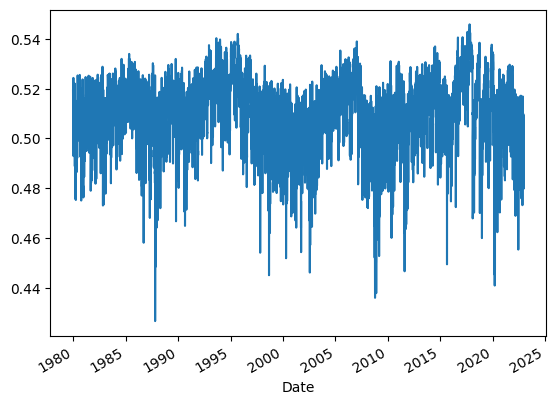

In [356]:
results["Probability"].plot()